In [1]:
from pathlib import Path

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LatitudeFormatter, LongitudeFormatter
import matplotlib.ticker as mticker
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import xarray as xr

mpl.rcParams["figure.figsize"] = 6, 4
mpl.rcParams["font.size"] = 12

### Load ERA5 data

In [4]:
ddir = Path("../data/processed/era5")
nct = ddir.joinpath("e5.moda.an.sfc.128_167_2t.ll025sc.197901-202212.nc")
ncs = ddir.joinpath("e5.moda.an.sfc.128_034_sstk.ll025sc.197901-202212.nc")
ncp = ddir.joinpath("e5.moda.fc.sfc.meanflux.235_055_mtpr.ll025sc.197901-202212.nc")

dst = xr.open_dataset(nct)
t = dst["VAR_2T"].sel(time=slice("1979-01", "2020-12"), longitude=slice(135, 210), latitude=slice(-20, -60))

dss = xr.open_dataset(ncs)
sst = dss["SSTK"].sel(time=slice("1979-01", "2020-12"), longitude=slice(135, 210), latitude=slice(-20, -60))


rho = 1000  # kg/m^3
dsp = xr.open_dataset(ncp)
p = (
    dsp["MTPR"].sel(time=slice("1979-01", "2020-12"), longitude=slice(135, 210), latitude=slice(-20, -60))
    / rho
    * 1000
    * 24
    * 3600
)

In [5]:
t_mn = t.weighted(np.cos(np.deg2rad(t.latitude))).mean(("latitude", "longitude"))
s_mn = sst.weighted(np.cos(np.deg2rad(sst.latitude))).mean(("latitude", "longitude"))
p_mn = p.weighted(np.cos(np.deg2rad(p.latitude))).mean(("latitude", "longitude"))

### Compute trends and p-values

In [11]:
def new_linregress(x, y):
    # Wrapper around scipy linregress to use in apply_ufunc
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    return np.array([slope, intercept, r_value, p_value, std_err])

In [12]:
ptmp = p.groupby("time.year").mean("time")
ttmp = t.groupby("time.year").mean("time")
stmp = sst.groupby("time.year").mean("time")

In [13]:
# return a new DataArray
pstats = xr.apply_ufunc(
    new_linregress,
    ptmp.year,
    ptmp,
    input_core_dims=[["year"], ["year"]],
    output_core_dims=[["parameter"]],
    vectorize=True,
    dask="parallelized",
    output_dtypes=["float64"],
    output_sizes={"parameter": 5},
)

tstats = xr.apply_ufunc(
    new_linregress,
    ttmp.year,
    ttmp,
    input_core_dims=[["year"], ["year"]],
    output_core_dims=[["parameter"]],
    vectorize=True,
    dask="parallelized",
    output_dtypes=["float64"],
    output_sizes={"parameter": 5},
)

sstats = xr.apply_ufunc(
    new_linregress,
    stmp.year,
    stmp,
    input_core_dims=[["year"], ["year"]],
    output_core_dims=[["parameter"]],
    vectorize=True,
    dask="parallelized",
    output_dtypes=["float64"],
    output_sizes={"parameter": 5},
)

/dev/shm/jobs/51557598/ipykernel_100599/2374844972.py:2: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  pstats = xr.apply_ufunc(
/dev/shm/jobs/51557598/ipykernel_100599/2374844972.py:14: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  tstats = xr.apply_ufunc(
/dev/shm/jobs/51557598/ipykernel_100599/2374844972.py:26: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  sstats = xr.apply_ufunc(


In [14]:
pslope = pstats.isel(parameter=0)*10 # Convert to per decade
ppval = pstats.isel(parameter=3)

tslope = tstats.isel(parameter=0)*10 # Convert to per decade
tpval = tstats.isel(parameter=3)

sslope = sstats.isel(parameter=0)*10 # Convert to per decade
spval = sstats.isel(parameter=3)

### Make plots for paper

In [15]:
def plotstat(axs, data, pval, title, label, annotation, cmap):
    if title == "SST":
        axs.add_feature(cfeature.LAND, color="tab:gray")
    axs.coastlines()
    axs.set_extent([145, 200, -60, -20], crs=ccrs.PlateCarree())
    gl = axs.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
    gl.xlocator = mticker.FixedLocator([160, 180])
    gl.ylocator = mticker.FixedLocator([-45, -30, -15])
    gl.top_labels = False
    gl.bottom_labels = True
    gl.left_labels = True
    gl.xformatter = LongitudeFormatter(dateline_direction_label=True)
    gl.xlabel_style = {'size': 8, 'color': 'k'}
    gl.ylabel_style = {'size': 8, 'color': 'k', 'rotation': 90}
    im = data.plot.pcolormesh(
        "longitude",
        "latitude",
        ax=axs,
        transform=ccrs.PlateCarree(),
        cbar_kwargs={"label": label, "extend": "both"},
        cmap=cmap
    )
    im.set_clim(-0.4, 0.4)

    levels = [0, 0.05, 0.1, 1]
    cs = pval.plot.contourf(
        "longitude",
        "latitude",
        ax=axs,
        transform=ccrs.PlateCarree(),
        levels=levels,
        hatches=["....", "", ""],
        colors="none",
        add_colorbar=False,
    )

    cs.set_edgecolor("tab:gray")
    cs.set_linewidth(0.0)
    
    axs.set_title(title)
    axs.annotate(annotation, xy=(-0.15, 1.0), xycoords="axes fraction", fontsize=18)
    
    return im

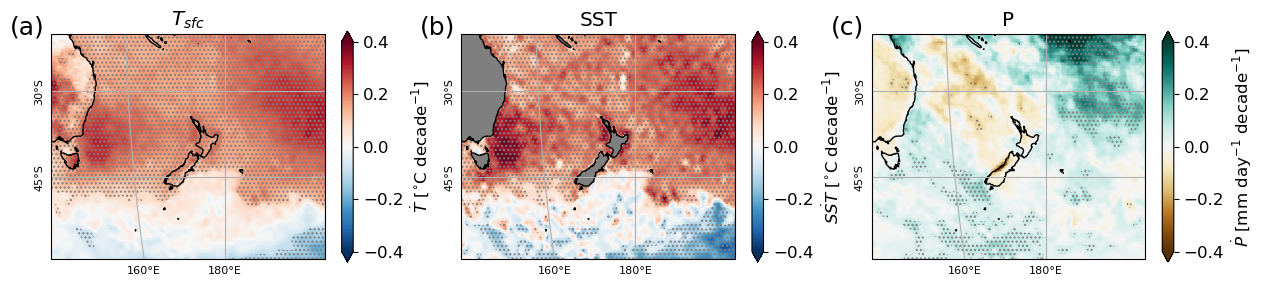

In [41]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 3), subplot_kw={"projection": ccrs.Robinson(central_longitude=180)})

im1 = plotstat(ax1, tslope, tpval, "$T_{sfc}$", r"$\dot{T}$ [$^{\circ}$C decade$^{-1}$]", "(a)", "RdBu_r")
im2 = plotstat(ax2, sslope, spval, "SST", r"$\dot{SST}$ [$^{\circ}$C decade$^{-1}$]", "(b)", "RdBu_r")
im2 = plotstat(ax3, pslope, ppval, "P", r"$\dot{P}$ [mm day$^{-1}$ decade$^{-1}$]", "(c)", "BrBG")

fig.savefig("../figures/era5_nz_trends_1979-2020.png", bbox_inches="tight", dpi=300)